In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False
# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']

from matplotlib.pylab import  rcParams
rcParams['figure.figsize']=20,6

In [2]:
data = pd.read_csv('C:/Users/acerpc/Desktop/data_folder/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#Month 是object类型，在时间序列分析中，我们需要现将数据转化为时间序列
airpass = pd.read_csv('C:/Users/acerpc/Desktop/data_folder/AirPassengers.csv',parse_dates=['Month'],
                    date_parser=lambda x:pd.to_datetime(x),index_col='Month')

In [4]:
airpass.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
ts = airpass['#Passengers']# convert to time series:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [6]:
# 检查索引格式
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [7]:
ts.shape

(144,)

In [8]:
#检索时间序列
# 1. 检索特定时间的序列值
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [9]:
# 2. 导入datetime的datetime模块，生成索引检索特定时间的序列值
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [10]:
#获取一定时间区间的序列值
ts['1949-01-01':'1950-01-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
1950-01-01    115
Name: #Passengers, dtype: int64

In [11]:
# 2. 切片，从开始到指定时间点
ts[:'1949-12-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [12]:
min(ts.index),max(ts.index)

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

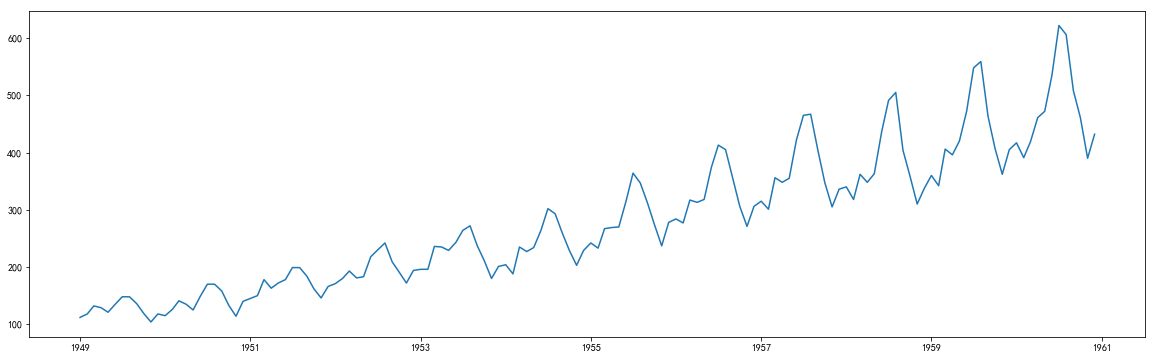

In [13]:
#1.平稳性检验
#绘制时序图
rcParams['figure.figsize']=20,6
plt.plot(ts)

In [14]:
#平稳性检验
from statsmodels.tsa.stattools import adfuller

def stationary_test(ts):
    # Determing rolling statistics
    rollingmean = ts.rolling(window=12,center=False).mean()
    rollingstd = ts.rolling(window=12).std()
    
    # Plot rolling statistics:
    orig = plt.plot(ts,color='blue',label='ts')
    mean = plt.plot(rollingmean,color='r',label='rollingmean')
    std = plt.plot(rollingstd,color='g',label='rollingstd')
    plt.legend(loc=0)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test:')
    adftest = adfuller(ts,autolag='AIC')
    output = pd.Series(adftest[:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        output['Critical Value ({})'.format(key)]=value
    print(output)

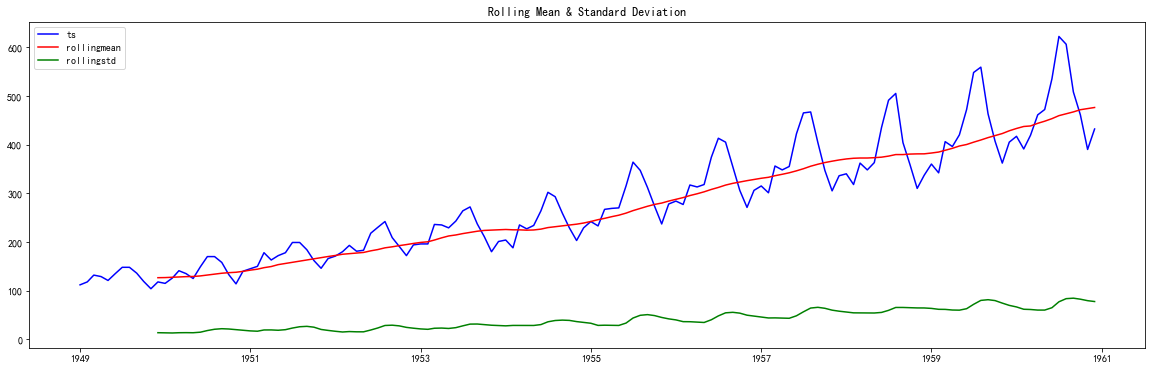

Results of Augmented Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
stationary_test(ts)

In [16]:
# 白噪声检验：Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox

def  randomness(ts,lags=10):
    rdtest = acorr_ljungbox(ts,lags)
    # 对上述函数求得的值进行语义描述
    output = pd.DataFrame(rdtest[1][:10],index=range(1,lags+1),columns=['p-value'])
    return output

In [17]:
randomness(ts)

,p-value
1,1.393231e-30
2,4.556318e-54
3,5.751088e-74
4,2.817731e-91
5,7.360195e-107
6,4.264008e-121
7,1.305463e-134
8,6.496271e-148
9,5.249370e-162
10,1.100789e-177


In [18]:
#平稳性处理 - 估计和消除趋势
#消除趋势的第一个诀窍是对数变换。
#因为，能清楚地看到我们的数据呈现一个显著的上升趋势。因此，我们可以应用log变换。当然还有其他的变换方式，如：平方根，立方根等等。

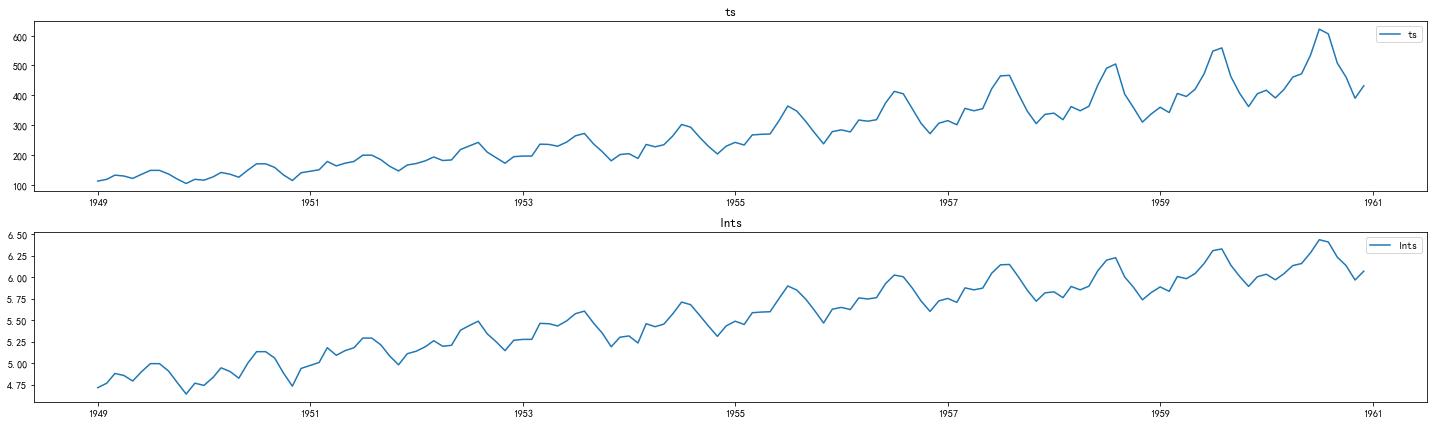

In [25]:
#对数变换(log transform)
lnts = np.log(ts)

# Plot original ts and log(ts):
plt.subplot(211)
plt.title('ts')
plt.plot(ts,label='ts')
plt.legend(loc=0)
plt.subplot(212)
plt.title('lnts')
plt.plot(lnts,label='lnts')
plt.legend(loc=0)
plt.tight_layout()

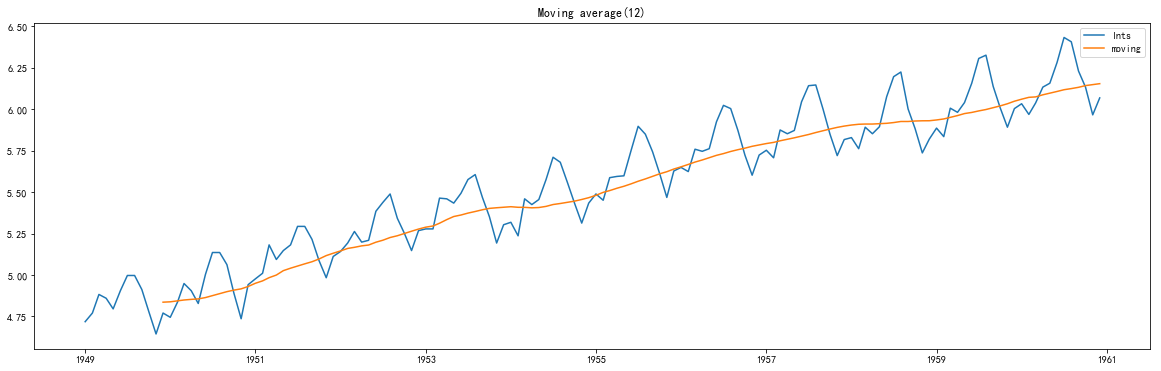

In [26]:
#平滑法/移动平均法(Moving average)
moving_ave = lnts.rolling(window=12,center=False).mean()
plt.plot(lnts,label='lnts')
plt.plot(moving_ave,label='moving')
plt.title('Moving average(12)')
plt.legend(loc='best');

In [29]:
# 移除移动平均值(消除趋势项)
re_trend = lnts-moving_ave
re_trend.head(20)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
Name: #Passengers, dtype: float64

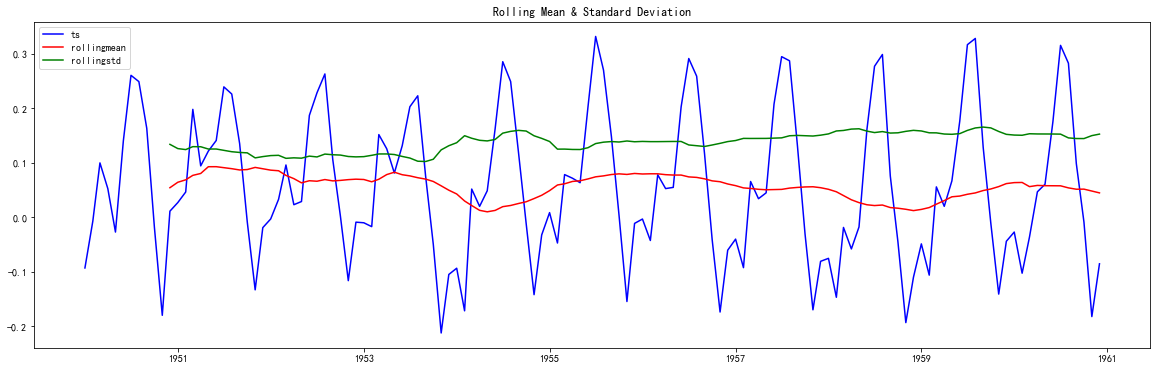

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.151143
p-value                          0.022993
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [30]:
stationary_test(re_trend[12:])

In [ ]:
'''p = 0.022235 < 0.05 我们可以说在95%的置信度下该序列平稳，均值和方差比平滑法相对稳定
然而，这种特殊方法的一个缺点是，必须严格定义时间周期。在这种情况下，我们可以取年平均，
但在复杂的情况下，比如预测股票价格，很难通过这种方法达到平稳。所以我们取一个“加权移动平均”(weighted moving average)，
该方法中最近的时序值被赋予更高的权重。
有很多方法可以分配权重。最常用的是指数加权移动平均，权重被分配到所有之前的值。'''

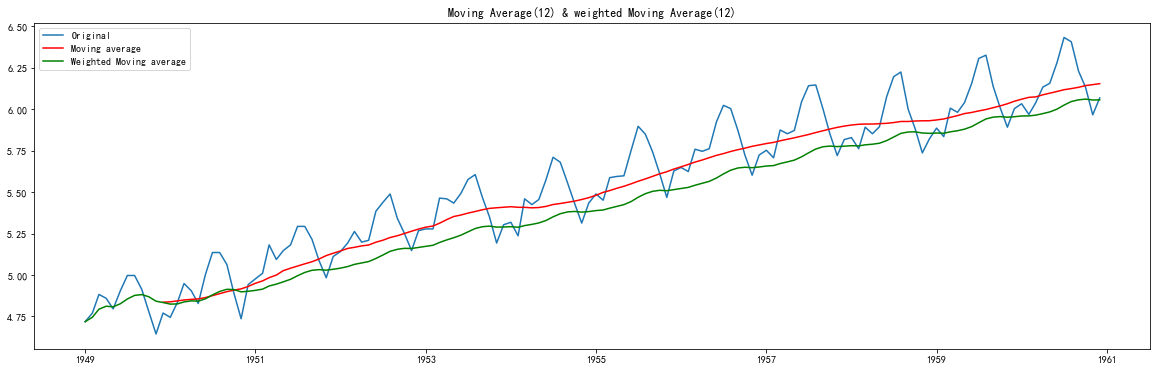

In [31]:
#指数加权平滑法(exponentially weighted moving average)
expsmh = lnts.ewm(min_periods=0,halflife=12,ignore_na=False,adjust=True).mean()
plt.plot(lnts, label='Original')
plt.plot(moving_ave, color='red', label='Moving average')
plt.plot(expsmh, color='green', label='Weighted Moving average')
# expwighted_avg.plot(style='k--')
plt.title('Moving Average(12) & weighted Moving Average(12)')
plt.legend(loc='best');

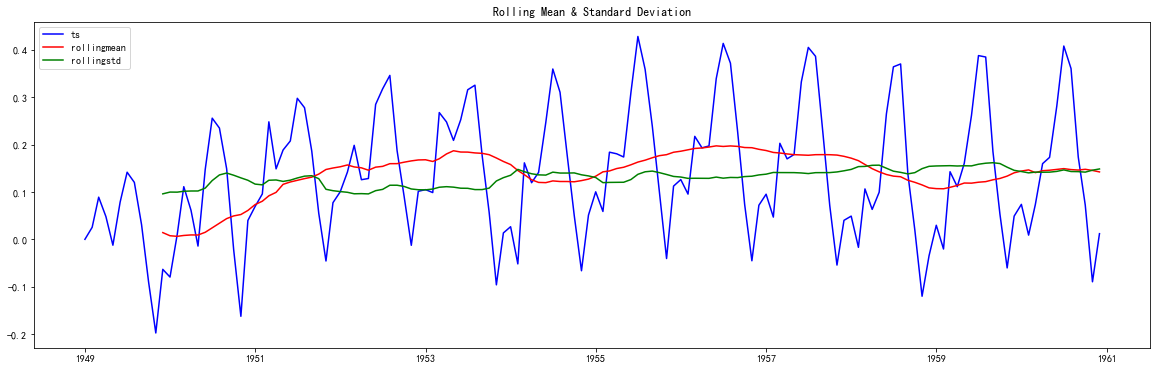

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [34]:
# 移除指数加权移动平均值
re_exptrend = lnts-expsmh
stationary_test(re_exptrend)

In [ ]:
#p = 0.005737 现在可以说在99%的置信度下该序列平稳，均值和方差更加稳定
# 并且注意这里没有产生缺失值

In [ ]:
#消除趋势和季节因素
#前面提到的方法不是对所有的问题都能做到很好的解决，尤其是在有比较明显的季节性因素存在的时候。
#下面我们会讲到两个常用而且有效地方法来消除趋势项和季节性因素：
'''差分：以一定的时间间隔做差分
   分解：对趋势和季节性进行建模，并将它们从模型中移除'''